##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 기본 회귀: 연비 예측

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

*회귀* 문제에서 목표는 가격이나 확률과 같은 연속된 값의 출력을 예측하는 것입니다. 이것은 클래스 목록에서 클래스를 선택하는 것이 목적인 *분류* 문제(예: 그림에 사과나 오렌지가 포함되어 있고 어떤 과일이 그림에 있는지 인식)와 대조됩니다.

이 튜토리얼은 고전적인 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터세트를 사용하고 1970년대 후반과 1980년대 초반 자동차의 연비를 예측하는 모델을 구축하는 방법을 보여줍니다. 이를 위해 해당 기간의 많은 자동차에 대한 설명을 모델에 제공해야 합니다. 이 설명에는 실린더, 배기량, 마력 및 무게와 같은 속성이 포함됩니다.

이 예에서는 Keras API를 사용합니다. (자세한 내용은 Keras [튜토리얼](https://www.tensorflow.org/tutorials/keras) 및 [가이드](https://www.tensorflow.org/guide/keras)를 참조하세요.)

In [3]:
# Use seaborn for pairplot.
# !pip install -q seaborn

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
# 소수점 자릿수 설정
np.set_printoptions(precision=3, suppress=True)

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


## Auto MPG 데이터셋

이 데이터세트는 [UCI 머신 러닝 리포지토리](https://archive.ics.uci.edu/ml/)에서 다운로드할 수 있습니다.


### 데이터 구하기

먼저 데이터셋을 다운로드합니다.

In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [7]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 정제하기

데이터세트에는 몇 가지 알 수 없는 값이 포함되어 있습니다.

In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

이 초기 튜토리얼을 간단하게 유지하려면 해당 행을 삭제하세요.

In [9]:
dataset = dataset.dropna()

`"Origin"` 열은 숫자가 아닌 범주형입니다. 따라서 다음 단계는 [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)를 사용하여 열의 값을 원-핫 인코딩하는 것입니다.

참고: 이러한 종류의 변환을 수행하도록 `tf.keras.Model`을 설정할 수 있지만 이 내용은 본 튜토리얼의 범위를 벗어납니다. 예를 보려면 [Keras 사전 처리 레이어를 사용하여 구조화된 데이터 분류](../structured_data/preprocessing_layers.ipynb) 또는 [CSV 데이터 로드](../load_data/csv.ipynb) 튜토리얼을 확인하세요.

In [10]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### 데이터를 훈련 세트와 테스트 세트로 분할

이제 데이터세트를 훈련 세트와 테스트 세트로 분할합니다. 모델의 최종 평가에 테스트 세트를 사용합니다.

In [12]:
# train : test = 8 : 2

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

### 데이터 조사하기

훈련 세트에서 몇 쌍의 열에 대한 공동 분포를 검토합니다.

맨 위 행은 연비(MPG)가 다른 모든 매개변수의 함수임을 나타냅니다. 다른 행은 각각이 서로 간의 함수임을 나타냅니다.

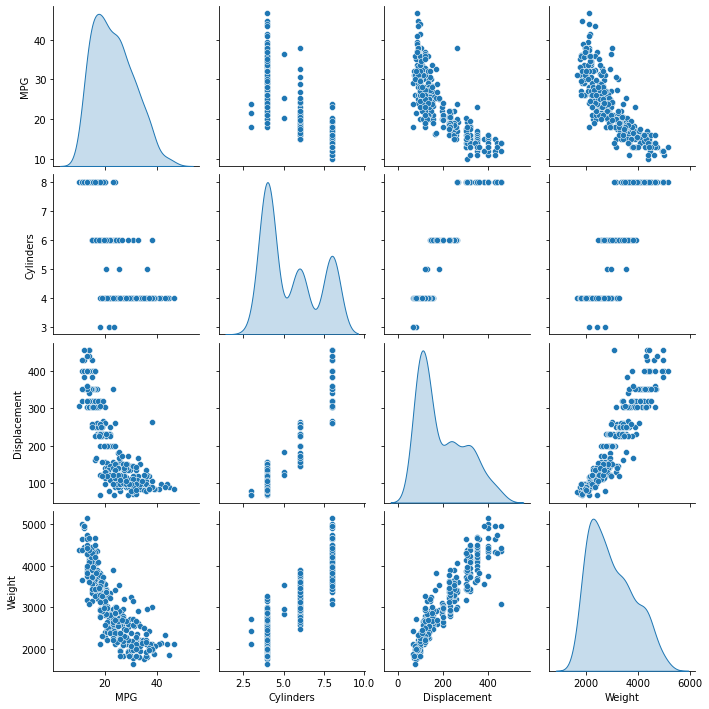

In [13]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

전체 통계도 확인해보겠습니다. 각 특성이 매우 다른 범위를 포괄하고 있는 것에 주목하세요.

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


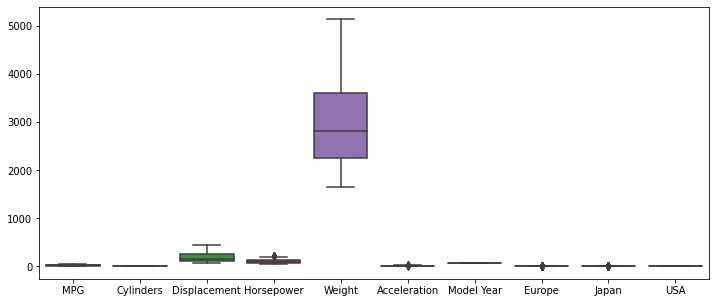

In [15]:
# Weight 스케일이 너무 큼
# 정규화 필요성
plt.figure(figsize=(12, 5))
sns.boxplot(data=train_dataset)

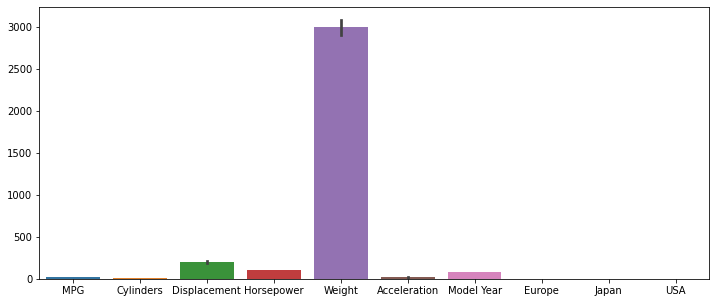

In [16]:
plt.figure(figsize=(12, 5))
sns.barplot(data=train_dataset)

### 특성과 레이블 분리하기

특성에서 대상 값("레이블")을 분리합니다. 이 레이블은 예측하도록 모델을 훈련할 값입니다.

In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# 제대로 분리되었는지 확인
train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((314, 9), (78, 9), (314,), (78,))

## 정규화

통계 표에서 각 특성의 범위가 얼마나 다른지 쉽게 알 수 있습니다.

In [18]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 *수렴할 수 있지만*, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

이것이 중요한 한 가지 이유는 특성에 모델 가중치가 곱해지기 때문입니다. 따라서 출력의 스케일과 그래디언트의 스케일은 입력 스케일의 영향을 받습니다.

모델은 특성 정규화 없이 수렴할 *수도* 있지만 정규화는 훈련을 훨씬 더 안정적으로 만듭니다.

참고: 원-핫 기능을 정규화하는 데에는 이점이 없습니다. 여기서는 단순성을 위해 수행했습니다. 전처리 레이어를 사용하는 방법에 대한 자세한 내용은 [전처리 레이어 작업하기](https://www.tensorflow.org/guide/keras/preprocessing_layers) 가이드 및 [Keras 전처리 레이어를 사용하여 구조화된 데이터 분류](../structured_data/preprocessing_layers.ipynb) 튜토리얼을 참조하세요.

### 정규화 레이어

`tf.keras.layers.Normalization`은 모델에 특성 정규화를 추가하는 깔끔하고 간단한 방법입니다.

첫 번째 단계는 레이어를 만드는 것입니다.

In [19]:
# tf에서 제공하는 정규화 전처리 기능
normalizer = tf.keras.layers.Normalization(axis=-1)

그런 다음 `Normalization.adapt`를 호출하여 전처리 레이어의 상태를 데이터에 맞춥니다.

In [20]:
normalizer.adapt(np.array(train_features))

평균과 분산을 계산하고 레이어에 저장합니다.

In [21]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


레이어가 호출되면 각 특성이 독립적으로 정규화된 입력 데이터를 반환합니다.

In [22]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## 선형 회귀

심층 신경망 모델을 구축하기 전에 하나 및 여러 변수를 사용하는 선형 회귀부터 시작합니다.

### 하나의 변수를 사용한 선형 회귀

단일 변수 선형 회귀로 시작하여 `'Horsepower'`에서 `'MPG'`를 예측합니다.

`tf.keras`를 사용하여 모델을 교육할 때는 일반적으로 모델 아키텍처를 정의하는 것으로 시작합니다. [일련의 단계를 나타내는](https://www.tensorflow.org/guide/keras/sequential_model) `tf.keras.Sequential` 모델을 사용합니다.

단일 변수 선형 회귀 모델에는 두 단계가 있습니다.

- `tf.keras.layers.Normalization` 전처리 레이어를 사용하여 `'Horsepower'` 입력 특성을 정규화합니다.
- 선형 변환($y = mx+b$)을 적용하여 선형 레이어(`tf.keras.layers.Dense`)로 1개의 출력을 생성합니다.

*입력*의 수는 `input_shape` 인수로 설정하거나 모델이 처음 실행될 때 자동으로 설정할 수 있습니다.

먼저 `'Horsepower'` 특성으로 구성된 NumPy 배열을 만듭니다. 그런 다음 `tf.keras.layers.Normalization`을 인스턴스화하고 상태를 `horsepower` 데이터에 맞춥니다.

In [23]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Keras 순차 모델 빌드:

In [24]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,

    # 출력층 활성화 함수 없이 항등 함수
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


이 모델은 `'Horsepower'`로부터 `'MPG'`를 예측합니다.

처음 10개의 'Horsepower' 값에 대해 훈련되지 않은 모델을 실행합니다. 결과는 좋지 않지만 예상되는 모양 `(10, 1)`을 가지고 있습니다.

In [25]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 112ms/step


array([[ 0.484],
       [ 0.273],
       [-0.893],
       [ 0.678],
       [ 0.613],
       [ 0.241],
       [ 0.727],
       [ 0.613],
       [ 0.16 ],
       [ 0.273]], dtype=float32)

모델이 빌드되면 `Model.compile` 메서드를 사용하여 훈련 절차를 구성합니다. 컴파일에 가장 중요한 인수는 `loss` 및 `optimizer`입니다. 이들이 최적화 대상(`mean_absolute_error`)과 방식(`tf.keras.optimizers.Adam` 사용)을 정의하기 때문입니다.

In [26]:
horsepower_model.compile(
    # "adam" 으로 지정하면 learning_rate 기본값 사용, 지정 불가능
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Keras `Model.fit`을 사용하여 100 epoch에 대한 훈련을 실행합니다.

In [27]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.42 s, sys: 179 ms, total: 4.6 s
Wall time: 4.44 s


`history` 객체에 저장된 통계를 사용하여 모델의 훈련 진행 상황을 시각화합니다.

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803731,4.201183,95
96,3.804928,4.197755,96
97,3.802560,4.198545,97
98,3.807540,4.211241,98
99,3.804522,4.186582,99


In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

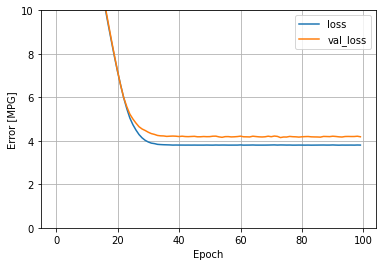

In [30]:
plot_loss(history)

나중을 위해 테스트 세트에서 결과를 수집합니다.

In [31]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

이것은 단일 변수 회귀이므로 모델의 예측을 입력의 함수로 쉽게 볼 수 있습니다.

In [32]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [33]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

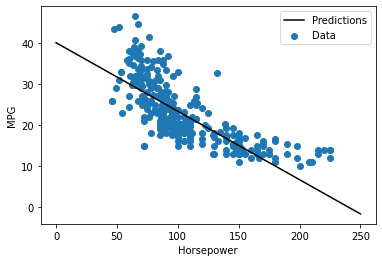

In [34]:
plot_horsepower(x, y)

### 다중 입력이 있는 선형 회귀

거의 동일한 설정을 사용하여 여러 입력을 기반으로 예측할 수 있습니다. 이 모델은 $m$가 행렬이고 $b$가 벡터라는 점을 제외하고 여전히 동일한 $y = mx+b$를 수행합니다.

이전에 정의하고 전체 데이터세트에 적용한 `normalizer`(`tf.keras.layers.Normalization(axis=-1)`)의 첫 레이어를 사용하여 2단계 Keras Sequential 모델을 다시 생성합니다.

In [35]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

입력 배치에 대해 `Model.predict`를 호출하면 각 예제에 대해 `units=1` 출력이 생성됩니다.

In [36]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 59ms/step


array([[-1.205],
       [ 0.229],
       [ 2.726],
       [ 0.464],
       [-1.088],
       [ 1.278],
       [-1.412],
       [-2.577],
       [ 0.295],
       [-2.594]], dtype=float32)

모델을 호출하면 가중치 행렬이 만들어집니다. `kernel` 가중치($y=mx+b$의 $m$)가 `(9, 1)` 모양인지 확인합니다.

In [37]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.326],
       [ 0.635],
       [-0.146],
       [ 0.766],
       [-0.494],
       [ 0.718],
       [-0.771],
       [ 0.041],
       [ 0.307]], dtype=float32)>

`Model.compile`을 사용하여 모델을 구성하고 `Model.fit`을 사용하여 100 epoch 동안 훈련합니다.

In [38]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [39]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.38 s, sys: 242 ms, total: 4.62 s
Wall time: 4.51 s


이 회귀 모델의 모든 입력을 사용하면 하나의 입력이 있는 `horsepower_model`보다 훨씬 더 낮은 훈련 및 검증 오류를 달성할 수 있습니다.

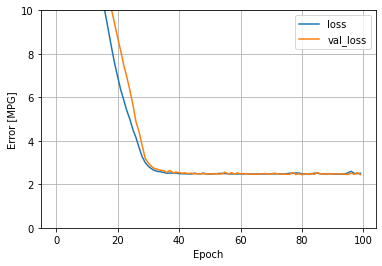

In [40]:
plot_loss(history)

나중을 위해 테스트 세트에서 결과를 수집합니다.

In [41]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## 심층 신경망(DNN)을 사용한 회귀

이전 섹션에서는 단일 및 다중 입력에 대해 두 개의 선형 모델을 구현했습니다.

여기에서는 단일 입력 및 다중 입력 DNN 모델을 구현합니다.

코드는 일부 "숨겨진" 비선형 레이어를 포함하도록 모델이 확장된다는 점을 제외하고는 기본적으로 동일합니다. 여기서 "숨겨진"이라는 말은 입력 또는 출력에 직접 연결되지 않음을 의미합니다.

이러한 모델에는 선형 모델보다 몇 개의 레이어가 더 포함됩니다.

- 이전과 같은 정규화 레이어(단일 입력 모델의 경우 `horsepower_normalizer` 및 다중 입력 모델의 경우 `normalizer` 사용)
- ReLU(`relu`) 활성화 함수 비선형성이 있는 두 개의 숨겨진 비선형 `Dense` 레이어
- 선형 `Dense` 단일 출력 레이어

두 모델 모두 동일한 훈련 절차를 사용하므로 `compile` 메서드는 아래의 `build_and_compile_model` 함수에 포함됩니다.

In [42]:
# 다중 입력을 해야 정보가 더 많기 때문에 성능이 더 좋게 나와야 하는데
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),

      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### DNN과 단일 입력을 사용한 회귀

입력으로 `'Horsepower'`만 사용하고 정규화 레이어로 `horsepower_normalizer`(앞서 정의)를 사용하여 DNN 모델을 만듭니다.

In [43]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

이 모델은 선형 모델보다 훈련 가능한 매개변수가 훨씬 많습니다.

In [44]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Keras `Model.fit`으로 모델 훈련:

In [45]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.03 s, sys: 252 ms, total: 5.28 s
Wall time: 5.71 s


이 모델은 선형 단일 입력 `horsepower_model`보다 약간 더 우수합니다.

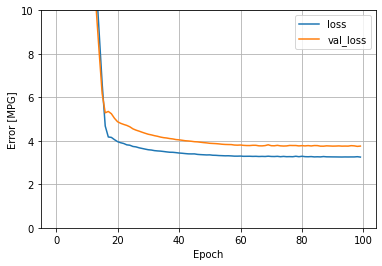

In [46]:
plot_loss(history)

예측을 `'Horsepower'`의 함수로 플로팅하면 이 모델이 숨겨진 레이어에서 제공하는 비선형성을 어떻게 이용하는지 알 수 있습니다.

In [47]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


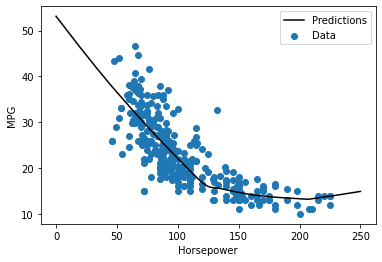

In [48]:
plot_horsepower(x, y)

나중을 위해 테스트 세트에서 결과를 수집합니다.

In [49]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### DNN 및 다중 입력을 사용한 회귀

모든 입력을 사용하여 이전 프로세스를 반복합니다. 모델의 성능은 검증 데이터세트에서 약간 향상됩니다.

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [51]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.45 s, sys: 239 ms, total: 5.69 s
Wall time: 5.75 s


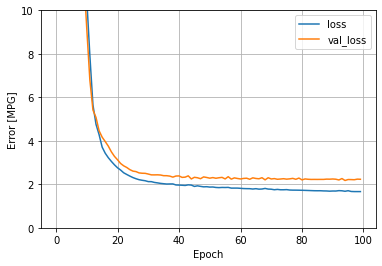

In [52]:
plot_loss(history)

테스트 세트에서 결과를 수집합니다.

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## 성능

모든 모델이 학습되었으므로 테스트 세트 성능을 검토할 수 있습니다.

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646469
linear_model,2.470821
dnn_horsepower_model,2.882576
dnn_model,1.698094


이러한 결과는 훈련 중에 관찰된 검증 오류와 일치합니다.

### 예측하기

이제 Keras `Model.predict`를 사용하여 테스트 세트에서 `dnn_model`로 예측을 수행하고 손실을 검토할 수 있습니다.

3/3 [==============================] - 0s 4ms/step


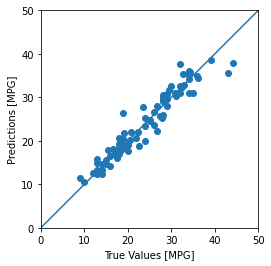

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


모델이 합리적으로 잘 예측하는 것으로 보입니다.

이제 오류 분포를 확인하세요.

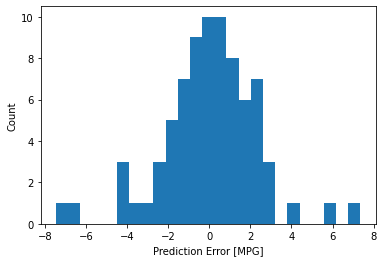

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

모델이 만족스러우면 나중에 사용할 수 있도록 `Model.save`로 저장합니다.

In [57]:
dnn_model.save('dnn_model')

모델을 다시 로드하면 동일한 출력이 제공됩니다.

In [58]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [59]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646469
linear_model,2.470821
dnn_horsepower_model,2.882576
dnn_model,1.698094
reloaded,1.698094


## 결론

이 노트북은 회귀 문제를 위한 기법을 소개합니다.

- 평균 제곱 오차(MSE)(`tf.keras.losses.MeanSquaredError`) 및 평균 절대 오차(MAE)(`tf.keras.losses.MeanAbsoluteError`)는 회귀 문제에 사용되는 일반적인 손실 함수입니다. MAE는 이상값에 덜 민감합니다. 분류 문제에는 여러 손실 함수가 사용됩니다.
- 마찬가지로 회귀에 사용되는 평가 메트릭은 분류와 다릅니다.
- 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
- 과대적합은 DNN 모델의 일반적인 문제이지만 이 튜토리얼에서는 문제가 되지 않았습니다. 이에 대한 추가적인 도움이 필요하면 [과대적합 및 과소적합](overfit_and_underfit.ipynb) 튜토리얼을 참조하세요.

## reshape

In [71]:
# 1차원 배열
a = np.arange(8)
print("차원 : ", a.ndim)
a

차원 :  1


array([0, 1, 2, 3, 4, 5, 6, 7])

In [72]:
# 2차원 배열로 전환
b = a.reshape(4, 2)
print("차원 : ", b.ndim)
b

차원 :  2


array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [73]:
# 3차원 배열로 전환
c = a.reshape(2, 2, 2)
print("차원 : ", c.ndim)
c

차원 :  3


array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [74]:
# 1차원으로 변경
c.reshape(-1)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [75]:
# 이것도 1차원
c.ravel()

array([0, 1, 2, 3, 4, 5, 6, 7])